In [185]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple
from tqdm import tqdm

In [186]:
class MLP(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2, T = 100):
        """
        input_dim: dimension of input (x and t concatenated)
        output_dim: dimension of output (drift term)
        """
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 32, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.time_emb = nn.Embedding(T, 32)
    
    def forward(self, x, t):
        """
        x: Tensor of shape (batch_size, 2)
        t: Tensor of shape (batch_size, 1)
        """
        # Concatenate x and t
        # print(x.shape, self.time_emb(t).shape)
        xt = torch.cat([x, self.time_emb(t)], dim=-1)  # Shape: (batch_size, 3)
        return self.net(xt)

In [187]:
class SchrödingerBridgeDataset(Dataset):
    def __init__(self, initial_samples: int, final_samples: int):
        """
        Args:
            initial_samples (int): Number of samples from the initial distribution.
            final_samples (int): Number of samples from the final distribution.
        """
        super(SchrödingerBridgeDataset, self).__init__()
        
        self.initial_data = self.uniform_distribution(final_samples)
        # self.final_data = self.uniform_distribution(initial_samples) + 2
        self.final_data = self.bimodal_distribution(final_samples)
        random_index = torch.randperm(len(self.final_data))
        self.final_data = self.final_data[random_index, :]
    @staticmethod
    def uniform_distribution(batch_size: int) -> torch.Tensor:
        """
        Uniform distribution in [-1, 1] x [-1, 1].
        """
        return torch.rand(batch_size, 1) * 2 - 1  # Shape: (batch_size, 2)
    
    @staticmethod
    def bimodal_distribution(batch_size: int) -> torch.Tensor:
        """
        Bimodal distribution with two Gaussian clusters.
        """
        half = batch_size // 2
        cluster1 = torch.randn(half, 1) + 2.0  # Cluster centered at (2)
        cluster2 = torch.randn(batch_size - half, 1) - 2.0  # Cluster centered at (-2)
        return torch.cat([cluster1, cluster2], dim=0)  # Shape: (batch_size, 1)
    
    def __len__(self):
        # Total samples are from both initial and final distributions
        return max(len(self.initial_data), len(self.final_data))
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of (x_initial, x_final).
        If one distribution has fewer samples, wrap around using modulo.
        """
        x_initial = self.initial_data[idx % len(self.initial_data)]
        x_final = self.final_data[idx % len(self.final_data)]
        return {"x0": x_initial, "xT":x_final}
    def plot(self):
        bins = np.linspace(-5, 5, 100)
        plt.hist(self.initial_data.detach().numpy(), bins = bins, alpha = 0.3, label = "inital_distribution")
        plt.hist(self.final_data.detach().numpy(), bins = bins, alpha = 0.3, label = "final_distribution")
        plt.legend()
        plt.grid()
        plt.show()
        

In [188]:
def lagevin(x:torch.Tensor, model:nn.Module, T:int, gamma:torch.Tensor, device = "cuda:0", reversed = False):
    traj_x = [x.unsqueeze(-1).detach().cpu()]
    grad_all = []
    model.eval()
    model.to(device)
    t = np.arange(0, T)
    t = t[::-1] if reversed else t
    gamma = gamma.to(device)
    xk = x
    for i in t:
        
        time = torch.full((xk.shape[0],), fill_value = i).to(device)
        # print(xk.shape, time.shape)
        xk = xk.to(device)
        xk = xk + model(xk, time) + torch.sqrt(2*gamma[i])*torch.randn_like(xk, device = device, dtype=torch.float32)
        traj_x.append(xk.unsqueeze(-1).detach().cpu())
        grad_all.append(traj_x[-2] - traj_x[-1])
    x_all = torch.cat(traj_x, dim = -1)
    grad_all = torch.cat(grad_all, dim = -1)
    return x_all, grad_all

In [189]:
def ou_process(x0, xT, T, sigma, inverse = False, device = "cuda:0"):
    x_all = torch.zeros((x0.shape[0], x0.shape[1], T+1)).to(device)
    grad_all = torch.zeros((x0.shape[0], x0.shape[1], T)).to(device)
    x0, xT = x0.to(device), xT.to(device)
    x_all[:,:,0] = x0
    for i in range(1,T+1):
        mu_i = (xT - x0)*i/T
        x_all[:, :, i] = x0 + mu_i + sigma[i-1]*torch.randn_like(x0).to(device)
        grad_all[:,:,i-1] = x_all[:,:,i] - x_all[:,:,i-1] if not inverse else -x_all[:,:,i] + x_all[:,:,i-1]
    return x_all.detach().cpu(), grad_all.detach().cpu()

In [190]:
def simple_dsb(dataset, batch_size, epoches, inner_epoches, f_model, b_model,f_optim, b_optim, sigma, T, device):
    dl = DataLoader(dataset=dataset, batch_size=batch_size)
    inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
    outer_pbar = tqdm(range(epoches), desc=f"Epoch", leave=False)
    sigma = sigma.to(device)
    total_loss_f = []
    total_loss_b = []
    forward_generated = []
    backward_generated = []
    f_model.train()
    b_model.eval()
    f_model, b_model = f_model.to(device), b_model.to(device)
    # for inner_epoch in inner_pbar:
    #     epoch_loss_b = 0
    #     epoch_loss_f = 0
        
    #     for data in dl:
    #         x0, xT = data['x0'].to(device), data["xT"].to(device)
    #         x_all, grad_all = ou_process(x0, xT, T = T, sigma=sigma, device=device)
    #         x_all, grad_all = x_all[..., :-1].to(device), grad_all.to(device)
    #         sample_t = torch.randint(high = T-1, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1), device = device)
    #         sample_xk = torch.gather(x_all, dim = -1, index = sample_t).to(device)
    #         grad_out = torch.gather(grad_all, dim = -1, index = sample_t).to(device)
    #         pred_out = f_model(sample_xk, sample_t.squeeze(-1))
    #         f_optim.zero_grad()
    #         loss_f = nn.functional.mse_loss(input = pred_out, target= grad_out)
    #         loss_f.backward()
    #         torch.nn.utils.clip_grad_norm_(f_model.parameters(), 1)
    #         f_optim.step()
    #         epoch_loss_f += loss_f.item()
        # inner_pbar.set_postfix({"inner_epoch":inner_epoch, "forward_loss": epoch_loss_f/len(dl)})
        # total_loss_f.append(epoch_loss_f/len(dl))
    
    for epoch in outer_pbar:
        epoch_loss_b = 0
        epoch_loss_f = 0
        # train the backward process 
        inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
        for inner_epoch in inner_pbar:
            f_model.eval()
            b_model.train()
            for data in dl:
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                sample_t = torch.randint(high = T, low = 1, dtype= torch.int64, size = (x0.shape[0], 1, 1)).cpu()
                with torch.no_grad():
                    x_all, grad_all = lagevin(x0, f_model, T = T, gamma=sigma, device = device, reversed=True)
                
                sample_xk = torch.gather(x_all, dim = -1, index = T - sample_t).to(device)
                grad_out = torch.gather(grad_all, dim = -1, index = T - sample_t).to(device)
                pred_out = b_model(sample_xk.to(device), (T-sample_t).to(device).squeeze(-1))
                b_optim.zero_grad()
                loss_b = nn.functional.mse_loss(input = pred_out, target= grad_out)
                loss_b.backward()
                torch.nn.utils.clip_grad_norm_(b_model.parameters(), 1)
                b_optim.step()
                epoch_loss_b += loss_b.item()
            forward_generated.append(x_all[:, 0, -1])
        total_loss_b.append(epoch_loss_b/len(dl)) 
        inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
        for inner_epoch in inner_pbar:
            b_model.eval()
            f_model.train()
            for data in dl:
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                sample_t = torch.randint(high = T-1, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1)).cpu()
                with torch.no_grad():
                    x_all, grad_all = lagevin(xT, f_model, T = T, gamma=sigma, device = device, reversed=False)
                sample_xk = torch.gather(x_all, dim = -1, index = sample_t).to(device)
                grad_out = torch.gather(grad_all, dim = -1, index = sample_t).to(device)
                pred_out = f_model(sample_xk, sample_t.to(device).squeeze(-1))
                f_model.zero_grad()
                loss_f = nn.functional.mse_loss(input = pred_out, target= grad_out)
                loss_f.backward()
                torch.nn.utils.clip_grad_norm_(f_model.parameters(), 1)
                f_optim.step()
                epoch_loss_f += loss_f.item()
            backward_generated.append(x_all[:, 0, -1])
        total_loss_f.append(epoch_loss_f/len(dl))
    plt.plot(total_loss_f) 
    plt.plot(total_loss_b) 
    
    # plt.plot(total_loss_b)
    # plt.show()
    return f_model, b_model, {"forward_gen":forward_generated, "backward_gen":backward_generated}

In [204]:
def simple_dsb(dataset, batch_size, epoches, inner_epoches, f_model, b_model,f_optim, b_optim, sigma, T, device):
    dl = DataLoader(dataset=dataset, batch_size=batch_size)
    inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
    outer_pbar = tqdm(range(epoches), desc=f"Epoch", leave=False)
    sigma = sigma.to(device)
    total_loss_f = []
    total_loss_b = []
    forward_generated = []
    backward_generated = []
    f_model.train()
    b_model.eval()
    f_model, b_model = f_model.to(device), b_model.to(device)
    
    for epoch in outer_pbar:
        epoch_loss_b = 0
        epoch_loss_f = 0
        # train the backward process 
        inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
        for inner_epoch in inner_pbar:
            f_model.eval()
            b_model.train()
            for data in dl:
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                sample_t = torch.randint(high = T, low = 1, dtype= torch.int64, size = (x0.shape[0], 1, 1)).cpu()
                with torch.no_grad():
                    x_all, grad_all = lagevin(x0, f_model, T = T, gamma=sigma, device = device, reversed=True)
                
                sample_xk = torch.gather(x_all, dim = -1, index = T - sample_t).to(device)
                grad_out = torch.gather(grad_all, dim = -1, index = T - sample_t).to(device)
                pred_out = b_model(sample_xk.to(device), (sample_t).to(device).squeeze(-1))
                b_optim.zero_grad()
                loss_b = nn.functional.mse_loss(input = pred_out, target= grad_out)
                loss_b.backward()
                torch.nn.utils.clip_grad_norm_(b_model.parameters(), 1)
                b_optim.step()
                epoch_loss_b += loss_b.item()
            forward_generated.append(x_all[:, 0, -1])
        total_loss_b.append(epoch_loss_b/len(dl)) 
        inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
        for inner_epoch in inner_pbar:
            b_model.eval()
            f_model.train()
            for data in dl:
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                sample_t = torch.randint(high = T-1, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1)).cpu()
                with torch.no_grad():
                    x_all, grad_all = lagevin(xT, f_model, T = T, gamma=sigma, device = device, reversed=False)
                sample_xk = torch.gather(x_all, dim = -1, index = sample_t).to(device)
                grad_out = torch.gather(grad_all, dim = -1, index = sample_t).to(device)
                pred_out = f_model(sample_xk, sample_t.to(device).squeeze(-1))
                f_model.zero_grad()
                loss_f = nn.functional.mse_loss(input = pred_out, target= grad_out)
                loss_f.backward()
                torch.nn.utils.clip_grad_norm_(f_model.parameters(), 1)
                f_optim.step()
                epoch_loss_f += loss_f.item()
            backward_generated.append(x_all[:, 0, -1])
        total_loss_f.append(epoch_loss_f/len(dl))
    plt.plot(total_loss_f) 
    plt.plot(total_loss_b) 
    return f_model, b_model, {"forward_gen":forward_generated, "backward_gen":backward_generated}

torch.Size([100, 1])


inner epoch:   0%|          | 0/2 [00:00<?, ?it/s]




inner epoch: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


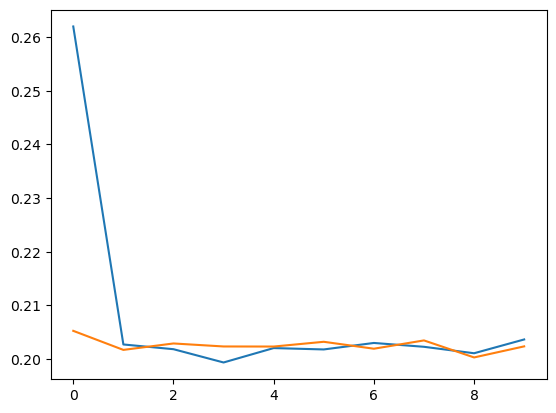

In [205]:
ds = SchrödingerBridgeDataset(50000, 50000)
T = 100
f_model = MLP(1, 256, 1, T)
b_model = MLP(1, 256, 1, T)
f_optim = torch.optim.Adam(f_model.parameters())
b_optim = torch.optim.Adam(b_model.parameters())
device = "cuda:0"
sigma = torch.from_numpy(np.concatenate([np.linspace(0, 1, int(T/2))*1e-1, (np.linspace(0, 1, int(T/2))[::-1])*1e-1])).unsqueeze(-1).to(torch.float32)
print(sigma.shape)
f_model, b_model, info = simple_dsb(dataset=ds, batch_size=5000, epoches = 10, inner_epoches=2, f_model = f_model, b_model = b_model, f_optim = f_optim, b_optim = b_optim, sigma = sigma, T = T, device = device)


In [193]:
# print(sigma)

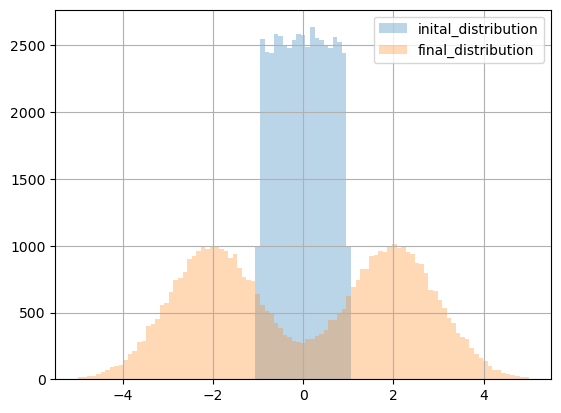

In [206]:
# print(len(info['forward_gen']))
ds.plot()

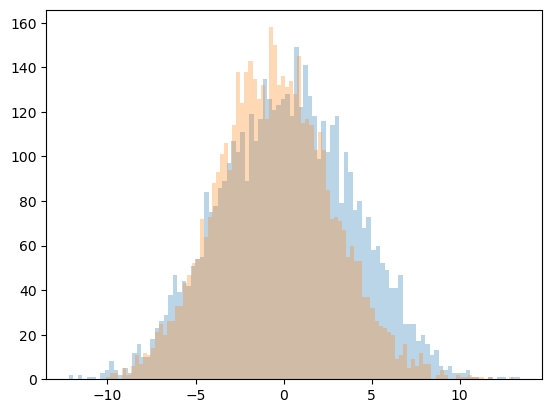

In [212]:
index = 5
plt.hist(info['backward_gen'][index], bins = 100, alpha = 0.3)
plt.hist(info['forward_gen'][index], bins = 100, alpha = 0.3)

plt.show()

In [165]:
def sample(model, T, dataset, batch_size, sigma, fb = "f", device = "cuda:0"):
    dl = DataLoader(dataset=dataset, batch_size=batch_size)
    model.eval()
    model, sigma = model.to(device), sigma.to(device)
    all_sample = []
    for data in tqdm(dl):
        # Make forward process 
        # print(data)
        x0, xT = data['x0'].to(device), data["xT"].to(device)
        x = x0 if fb == 'f' else xT
        x_all, _ = lagevin(x, model, T, sigma, device, reversed = False)
        all_sample.append(x_all)
    all_sample = torch.cat(all_sample, axis = 0)
    return all_sample

In [166]:
x_all = sample(model= b_model, T = T, dataset = ds, batch_size=100, sigma = sigma.to(torch.float32), fb = "f")
x_all = x_all.detach().numpy()
print(x_all.shape)

100%|██████████| 500/500 [00:18<00:00, 27.05it/s]

(50000, 1, 101)


In [167]:
print(x_all[:, 0, -1])

[ 1.4642398   2.6635485   3.0419927  ... -1.9844477  -0.41220295
  3.6499586 ]


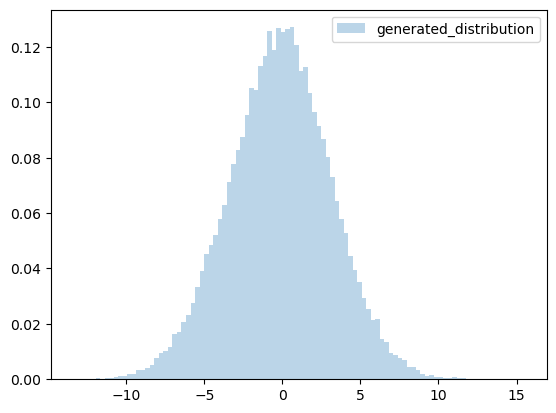

In [168]:
# bins = np.linspace(-10,10,50)
# plt.hist(x_all[:, 0, 0], bins = bins, alpha = 0.3, label = "initial_distribution", density = True)
plt.hist(x_all[:, 0, -1], bins = 100, alpha = 0.3, label = "generated_distribution", density = True)
# plt.hist(ds.final_data.numpy(), bins = 100, alpha = 0.3, label = "final_distribution", density = True)
plt.legend()
plt.show()

In [172]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the MLP model with embedding for time
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, time_dim, embedding_dim=128):
        super(MLP, self).__init__()
        self.time_embedding = nn.Embedding(time_dim, embedding_dim)
        self.network = nn.Sequential(
            nn.Linear(input_dim + embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x, time):
        # x: [batch_size, input_dim]
        # time: [batch_size] (integer tensor)
        time_embed = self.time_embedding(time)  # [batch_size, embedding_dim]
        x = torch.cat([x, time_embed], dim=1)  # [batch_size, input_dim + embedding_dim]
        out = self.network(x)  # [batch_size, output_dim]
        return out

def lagevin(x: torch.Tensor, model: nn.Module, T: int, gamma: torch.Tensor, device="cuda:0", reversed=False):
    traj_x = [x.unsqueeze(-1).detach().cpu()]
    grad_all = []
    model.eval()
    model.to(device)
    t = np.arange(0, T)
    t = t[::-1] if reversed else t
    gamma = gamma.to(device)
    xk = x.to(device)
    for i in t:
        # 'i' is an integer time step
        # Pass integer time indices
        time = torch.full((xk.shape[0],), fill_value=i, dtype=torch.long, device=device)  # Integer tensor
        # Add Gaussian noise
        noise = torch.sqrt(2 * gamma[i]) * torch.randn_like(xk, device=device, dtype=torch.float32)
        # Model expects integer time indices
        model_output = model(xk, time)
        xk = xk + model_output + noise
        traj_x.append(xk.unsqueeze(-1).detach().cpu())
        grad_all.append(traj_x[-2] - traj_x[-1])
    x_all = torch.cat(traj_x, dim=-1)  # Shape: [batch_size, x_dim, T]
    grad_all = torch.cat(grad_all, dim=-1)  # Shape: [batch_size, x_dim, T-1]
    return x_all, grad_all

def simple_dsb(dataset, batch_size, epoches, inner_epoches, f_model, b_model, f_optim, b_optim, sigma, T, device):
    dl = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    total_loss_f = []
    total_loss_b = []
    forward_generated = []
    backward_generated = []
    f_model.to(device)
    b_model.to(device)
    
    for epoch in tqdm(range(epoches), desc="Epoch"):
        epoch_loss_b = 0
        epoch_loss_f = 0
        
        # Train the backward process
        b_model.train()
        f_model.eval()
        for inner_epoch in tqdm(range(inner_epoches), desc="Inner Epoch (Backward)", leave=False):
            for data in dl:
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                with torch.no_grad():
                    x_all, grad_all = lagevin(x0, f_model, T=T, gamma=sigma, device=device, reversed=True)
                
                # Sample random time steps (integer)
                sample_t = torch.randint(low=1, high=T, dtype=torch.long, size=(x0.shape[0],)).to(device)
                
                # Gather the sampled xk and grad_out
                batch_indices = torch.arange(x_all.size(0)).to(device)
                sample_xk = x_all[batch_indices, :, T - sample_t]  # Shape: [batch_size, x_dim]
                grad_out = grad_all[batch_indices, :, T - sample_t - 1]  # Shape: [batch_size, x_dim]
                
                # Pass integer time indices to the model
                pred_out = b_model(sample_xk, (T - sample_t))
                
                b_optim.zero_grad()
                loss_b = nn.functional.mse_loss(pred_out, grad_out)
                loss_b.backward()
                torch.nn.utils.clip_grad_norm_(b_model.parameters(), 1)
                b_optim.step()
                epoch_loss_b += loss_b.item()
            forward_generated.append(x_all[:, 0, -1].detach().cpu())
        
        avg_loss_b = epoch_loss_b / len(dl)
        total_loss_b.append(avg_loss_b)
        
        # Train the forward process
        f_model.train()
        b_model.eval()
        for inner_epoch in tqdm(range(inner_epoches), desc="Inner Epoch (Forward)", leave=False):
            for data in dl:
                x0, xT = data['x0'].to(device), data["xT"].to(device)
                with torch.no_grad():
                    x_all, grad_all = lagevin(xT, f_model, T=T, gamma=sigma, device=device, reversed=False)
                
                # Sample random time steps (integer)
                sample_t = torch.randint(low=0, high=T-1, dtype=torch.long, size=(x0.shape[0],)).to(device)
                
                # Gather the sampled xk and grad_out
                batch_indices = torch.arange(x_all.size(0)).to(device)
                sample_xk = x_all[batch_indices, :, sample_t]  # Shape: [batch_size, x_dim]
                grad_out = grad_all[batch_indices, :, sample_t]  # Shape: [batch_size, x_dim]
                
                # Pass integer time indices to the model
                pred_out = f_model(sample_xk, sample_t)
                
                f_optim.zero_grad()
                loss_f = nn.functional.mse_loss(pred_out, grad_out)
                loss_f.backward()
                torch.nn.utils.clip_grad_norm_(f_model.parameters(), 1)
                f_optim.step()
                epoch_loss_f += loss_f.item()
            backward_generated.append(x_all[:, 0, -1].detach().cpu())
        
        avg_loss_f = epoch_loss_f / len(dl)
        total_loss_f.append(avg_loss_f)
        
        # Update progress bars
        tqdm.write(f"Epoch {epoch+1}/{epoches} - Loss Forward: {avg_loss_f:.4f}, Loss Backward: {avg_loss_b:.4f}")
    
    # Plot the losses
    plt.figure(figsize=(10,5))
    plt.plot(total_loss_f, label='Forward Loss')
    plt.plot(total_loss_b, label='Backward Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.show()
    
    return f_model, b_model, {"forward_gen": forward_generated, "backward_gen": backward_generated}

# Example Usage
# Assuming SchrödingerBridgeDataset is defined appropriately

# Define a dummy SchrödingerBridgeDataset for demonstration
class SchrödingerBridgeDataset(torch.utils.data.Dataset):
    def __init__(self, size_x0, size_xT):
        super(SchrödingerBridgeDataset, self).__init__()
        self.size_x0 = size_x0
        self.size_xT = size_xT
        self.x0 = torch.randn(size_x0, 1)  # Example data
        self.xT = torch.randn(size_xT, 1)  # Example data
    
    def __len__(self):
        return min(self.size_x0, self.size_xT)
    
    def __getitem__(self, idx):
        return {'x0': self.x0[idx], 'xT': self.xT[idx]}

# Initialize dataset
ds = SchrödingerBridgeDataset(50000, 50000)

# Define parameters
T = 100
f_model = MLP(input_dim=1, hidden_dim=256, output_dim=1, time_dim=T, embedding_dim=128)
b_model = MLP(input_dim=1, hidden_dim=256, output_dim=1, time_dim=T, embedding_dim=128)
f_optim = torch.optim.Adam(f_model.parameters(), lr=1e-3)
b_optim = torch.optim.Adam(b_model.parameters(), lr=1e-3)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Define a linear sigma schedule (adjust as needed)
sigma = torch.linspace(0.1, 1.0, steps=T).to(torch.float32).unsqueeze(-1)

# Train the model
f_model, b_model, info = simple_dsb(
    dataset=ds,
    batch_size=5000,
    epoches=10,
    inner_epoches=2,
    f_model=f_model,
    b_model=b_model,
    f_optim=f_optim,
    b_optim=b_optim,
    sigma=sigma,
    T=T,
    device=device
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)